In [1]:
import importlib
import os

from art.utils.benchmarking.load_trajectories import load_trajectories
from art.utils.benchmarking.charts import percentage_comparison_bar_chart, training_progress_chart
import art.utils.benchmarking.charts
from art.utils.benchmarking.types import BenchmarkModelKey
from art.utils.output_dirs import get_benchmarks_dir
from art.utils.get_repo_root_path import get_repo_root_path

importlib.reload(art.utils.benchmarking.charts)

project_name = "2048"

# await load_trajectories.bust_cache()
df = await load_trajectories(
    api_path="./.art",
    project_name=project_name,
    models=["003", "gpt-4o", "gpt-4.1", "gpt-4o-mini"],
)

# benchmarks_root_dir = "./.art"
benchmarks_root_dir = f"{get_repo_root_path()}/assets/benchmarks"

benchmarks_dir = get_benchmarks_dir(project=project_name, path=benchmarks_root_dir)

os.makedirs(benchmarks_dir, exist_ok=True)

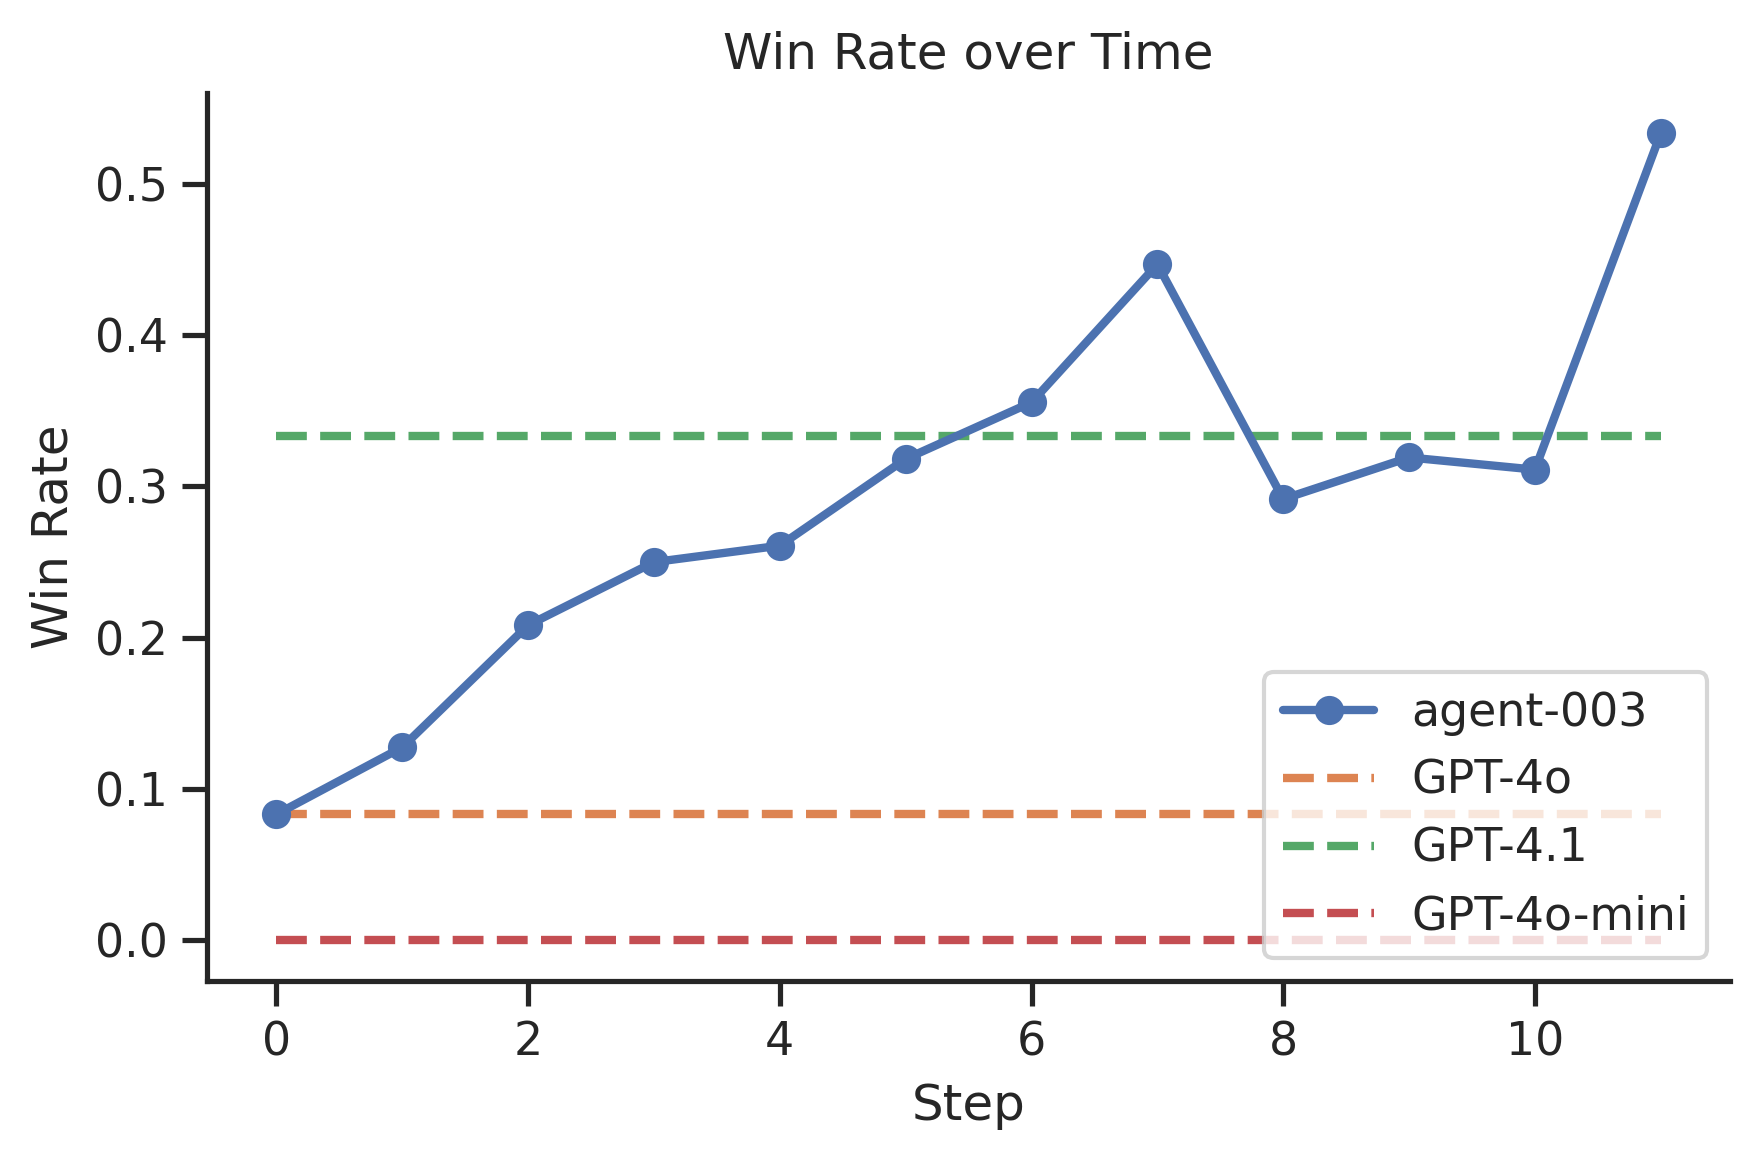

In [2]:
line_graph = training_progress_chart(
    df,
    "win",
    models=[
        BenchmarkModelKey("003", "agent-003", "train"),
        BenchmarkModelKey("gpt-4o", "GPT-4o"),
        BenchmarkModelKey("gpt-4.1", "GPT-4.1"),
        BenchmarkModelKey("gpt-4o-mini", "GPT-4o-mini"),
    ],
    title="Win Rate over Time",
    y_label="Win Rate",
)
line_graph.savefig(
    f"{benchmarks_dir}/accuracy-training-progress.svg"
)

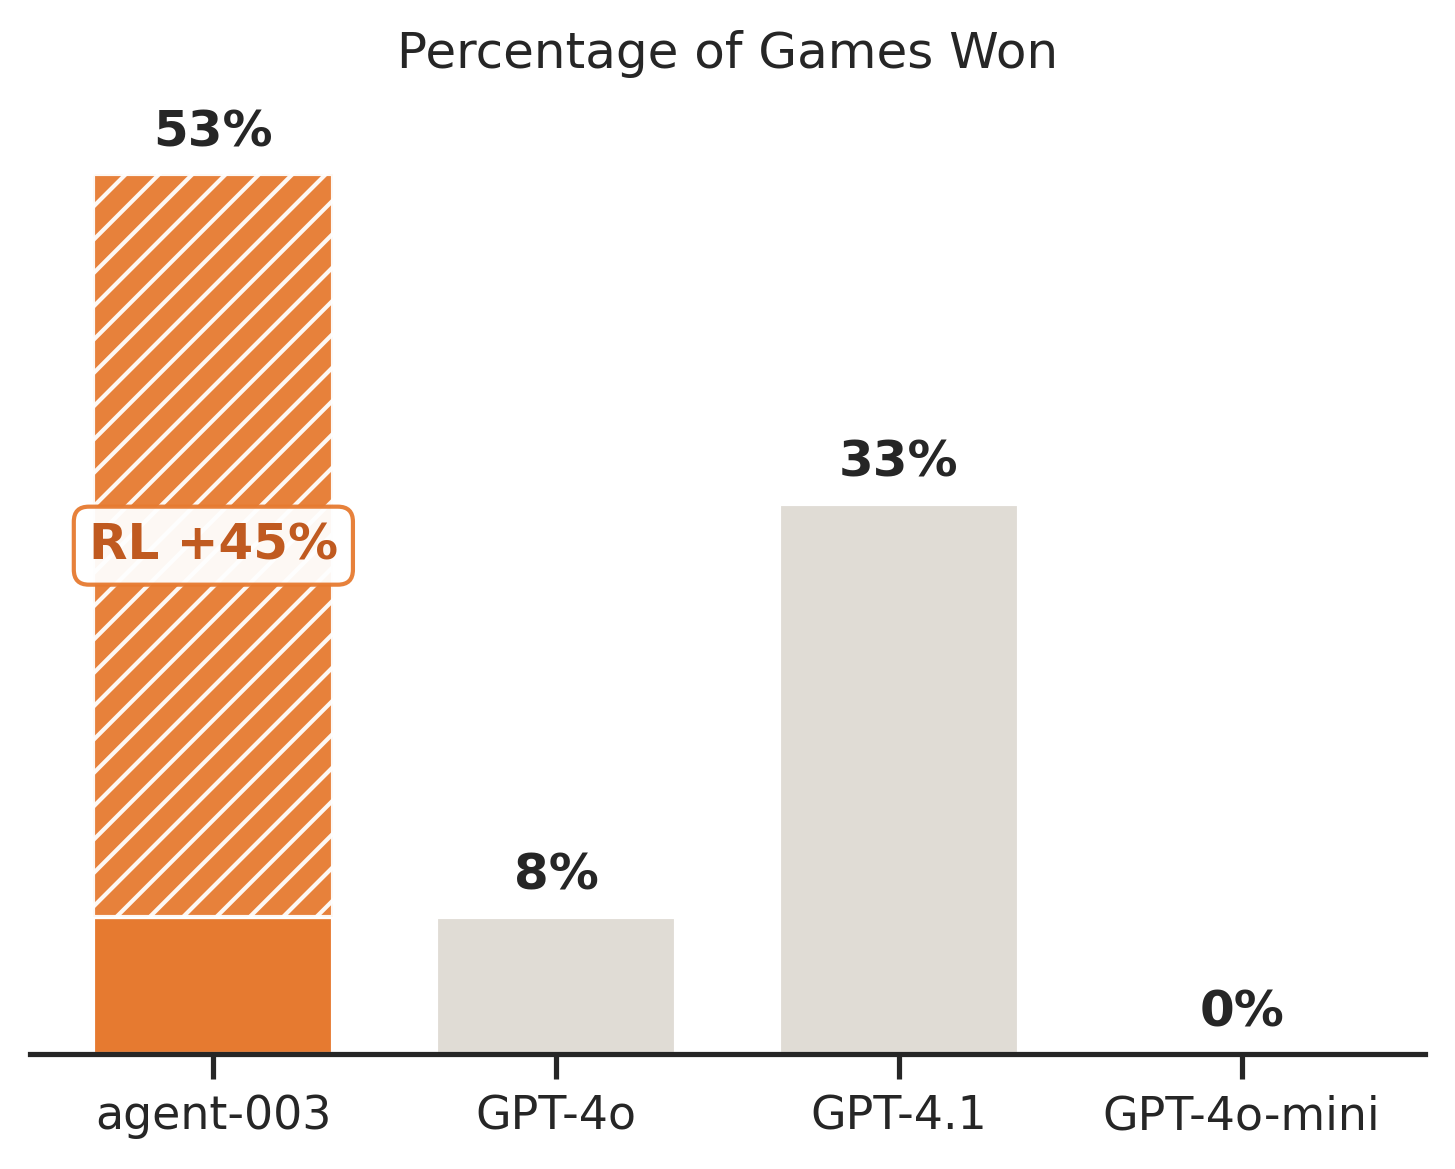

In [3]:
bar_chart = percentage_comparison_bar_chart(
    df,
    metric_name="win",
    models=[
        BenchmarkModelKey("003", "agent-003", "train"),
        BenchmarkModelKey("gpt-4o", "GPT-4o"),
        BenchmarkModelKey("gpt-4.1", "GPT-4.1"),
        BenchmarkModelKey("gpt-4o-mini", "GPT-4o-mini"),
    ],
    title="Percentage of Games Won",
)
bar_chart.savefig(
    f"{benchmarks_dir}/accuracy-comparison.svg"
)